##### Copyright 2018 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Text classification with an RNN

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/text_classification_rnn"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/text_classification_rnn.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This text classification tutorial trains a [recurrent neural network](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network) on the [IMDB large movie review dataset](http://ai.stanford.edu/~amaas/data/sentiment/) for sentiment analysis.

## Setup

In [1]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf



tfds.disable_progress_bar()

Import `matplotlib` and create a helper function to plot graphs:

In [2]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


The IMDB large movie review dataset is a *binary classification* dataset—all the reviews have either a *positive* or *negative* sentiment.

Download the dataset using [TFDS](https://www.tensorflow.org/datasets). See the [loading text tutorial](https://www.tensorflow.org/tutorials/load_data/text) for details on how to load this sort of data manually.


In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

Initially this returns a dataset of (text, label pairs):

In [4]:
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [6]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [7]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"Incredibly ARTISTIC NOBODY COULD MAKE THEM NOW I THINK.It seem to be perfect the biggest and the greatest musical ever made listen to the beautiful songs the are quite poetry.I'M Italian AND ADMIRED BY American MUSICAL. why can't you do something like that now?American were the best and for that i absolutely show my devotion to you with this movie.there are words to describes the perfection of this movie. all of a sudden my heart sings, what makes the sunset? i fall in love to easily,jealousy...and the scene with Tom and Jerry. the greatest without reserve. if you you doesn't know your eyes are not open my friends you must see it and appreciate...wake up!"
 b'Kurt Thomas stars as Jonathan Cabot some kind of a gymnast who trains for a special game which involves being hunted by a group of ninjas, but those ninjas won\'t stand a chance, especially since Cabot is a gymnast! Taken as a whole Gymkata is one helluva bad movie, the atrocious acting, the god-awful script and really 

## Create the text encoder

The raw text loaded by `tfds` needs to be processed before it can be used in a model. The simplest way to process text for training is using the `TextVectorization` layer. This layer has many capabilities, but this tutorial sticks to the default behavior.

Create the layer, and pass the dataset's text to the layer's `.adapt` method:

In [8]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

The `.adapt` method sets the layer's vocabulary. Here are the first 20 tokens. After the padding and unknown tokens they're sorted by frequency:

In [9]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

Once the vocabulary is set, the layer can encode text into indices. The tensors of indices are 0-padded to the longest sequence in the batch (unless you set a fixed `output_sequence_length`):

In [10]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[927,   1,   1, ...,   0,   0,   0],
       [  1,   1, 390, ...,   0,   0,   0],
       [ 10, 103,  11, ...,   0,   0,   0]])

With the default settings, the process is not completely reversible. There are three main reasons for that:

1. The default value for `preprocessing.TextVectorization`'s `standardize` argument is `"lower_and_strip_punctuation"`.
2. The limited vocabulary size and lack of character-based fallback results in some unknown tokens.

In [11]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"Incredibly ARTISTIC NOBODY COULD MAKE THEM NOW I THINK.It seem to be perfect the biggest and the greatest musical ever made listen to the beautiful songs the are quite poetry.I'M Italian AND ADMIRED BY American MUSICAL. why can't you do something like that now?American were the best and for that i absolutely show my devotion to you with this movie.there are words to describes the perfection of this movie. all of a sudden my heart sings, what makes the sunset? i fall in love to easily,jealousy...and the scene with Tom and Jerry. the greatest without reserve. if you you doesn't know your eyes are not open my friends you must see it and appreciate...wake up!"
Round-trip:  incredibly [UNK] [UNK] could make them now i [UNK] seem to be perfect the [UNK] and the greatest musical ever made [UNK] to the beautiful songs the are quite [UNK] [UNK] and [UNK] by american musical why cant you do something like that [UNK] were the best and for that i absolutely show my [UNK] to you with t

## Create the model

![A drawing of the information flow in the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/bidirectional.png?raw=1)

Above is a diagram of the model.

1. This model can be build as a `tf.keras.Sequential`.

2. The first layer is the `encoder`, which converts the text to a sequence of token indices.

3. After the encoder is an embedding layer. An embedding layer stores one vector per word. When called, it converts the sequences of word indices to sequences of vectors. These vectors are trainable. After training (on enough data), words with similar meanings often have similar vectors.

  This index-lookup is much more efficient than the equivalent operation of passing a one-hot encoded vector through a `tf.keras.layers.Dense` layer.

4. A recurrent neural network (RNN) processes sequence input by iterating through the elements. RNNs pass the outputs from one timestep to their input on the next timestep.

  The `tf.keras.layers.Bidirectional` wrapper can also be used with an RNN layer. This propagates the input forward and backwards through the RNN layer and then concatenates the final output.

  * The main advantage of a bidirectional RNN is that the signal from the beginning of the input doesn't need to be processed all the way through every timestep to affect the output.  

  * The main disadvantage of a bidirectional RNN is that you can't efficiently stream predictions as words are being added to the end.

5. After the RNN has converted the sequence to a single vector the two `layers.Dense` do some final processing, and convert from this vector representation to a single logit as the classification output.


The code to implement this is below:

In [12]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

Please note that Keras sequential model is used here since all the layers in the model only have single input and produce single output. In case you want to use stateful RNN layer, you might want to build your model with Keras functional API or model subclassing so that you can retrieve and reuse the RNN layer states. Please check [Keras RNN guide](https://www.tensorflow.org/guide/keras/rnn#rnn_state_reuse) for more details.

The embedding layer [uses masking](https://www.tensorflow.org/guide/keras/masking_and_padding) to handle the varying sequence-lengths. All the layers after the `Embedding` support masking:

In [13]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


To confirm that this works as expected, evaluate a sentence twice. First, alone so there's no padding to mask:

In [15]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
# Convert the NumPy array to a TensorFlow tensor of strings
predictions = model.predict(tf.constant([sample_text]))
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
[0.00594061]


Now, evaluate it again in a batch with a longer sentence. The result should be identical:

In [17]:
# predict on a sample text with padding

padding = "the " * 2000
# Convert the NumPy array of strings to a TensorFlow tensor of strings
predictions = model.predict(tf.constant(np.array([sample_text, padding])))
print(predictions[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step
[0.00594061]


Compile the Keras model to configure the training process:

In [18]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## Train the model

In [19]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 26s 56ms/step - accuracy: 0.5289 - loss: 0.6722 - val_accuracy: 0.7984 - val_loss: 0.4150
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 39s 54ms/step - accuracy: 0.8263 - loss: 0.3884 - val_accuracy: 0.8281 - val_loss: 0.3580
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 82s 160ms/step - accuracy: 0.8505 - loss: 0.3382 - val_accuracy: 0.8500 - val_loss: 0.3404
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 40s 53ms/step - accuracy: 0.8581 - loss: 0.3272 - val_accuracy: 0.8474 - val_loss: 0.3424
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - accuracy: 0.8623 - loss: 0.3193 - val_accuracy: 0.8552 - val_loss: 0.3349
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - accuracy: 0.8634 - loss: 0.3139 - val_accuracy: 0.8589 - val_loss: 0.3425
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 82s 158ms/step - accuracy: 0.8649 - loss: 0.3146 - val_accuracy: 0.8589 - val_loss: 0.3253
Epoch 8/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/step - accuracy: 0.8688 - loss: 0.3071 

In [20]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.8414 - loss: 0.3261
Test Loss: 0.3262796401977539
Test Accuracy: 0.841759979724884


(0.0, 0.621672323346138)

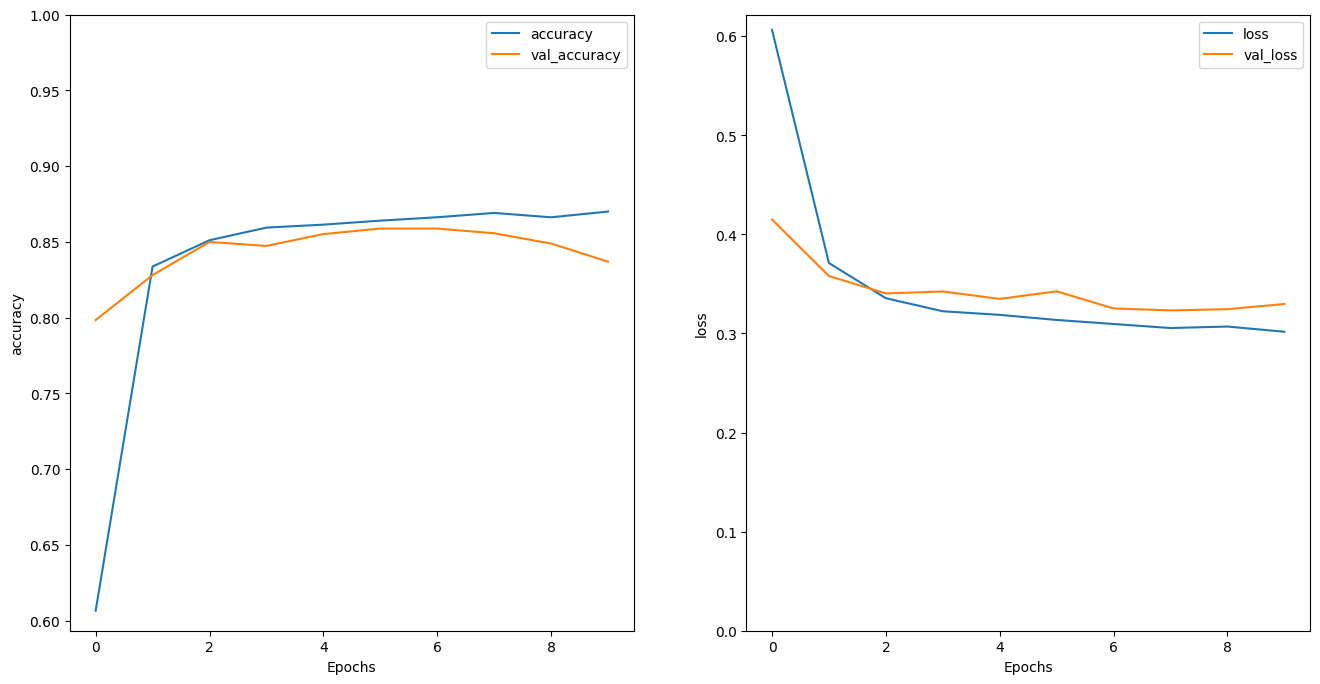

In [21]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

Check out other existing recurrent layers such as [GRU layers](https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRU).

If you're interested in building custom RNNs, see the [Keras RNN Guide](https://www.tensorflow.org/guide/keras/rnn).
